<h3>ANN for classification - Example 1 - Mobile price classifier</h3>

**This version uses PyTorch as Keras backend (and GPU!)**

Install PyTorch with GPU first though:
https://pytorch.org/get-started/locally/

CUDA 12.8 should be OK!

**NOTE! Using Torch in Keras (even with GPU) is usually OK with the most common neural networks. However, expect bugs or errors with more advanced neural network types, since they might not always be fully supported.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras import layers

# pip install torch
# see PyTorch website for the GPU installation package
# (Get started -generator): https://pytorch.org/get-started/locally/
import torch

print("Keras backend:", keras.backend.backend())  # should print 'torch'
print("Torch CUDA available:", torch.cuda.is_available())  # should be True
print("Device:", torch.cuda.get_device_name(0))


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

Keras backend: torch
Torch CUDA available: True
Device: NVIDIA RTX 2000 Ada Generation Laptop GPU


You should see CUDA / GPU information above if Torch with GPU support is enabled.

<b>Load the data</b>

In [2]:
df = pd.read_csv("mobilepricerangeclass.csv")
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


<b>Let's compare the variables, can we drop something?</b>

<b>First version: Without any optimizations, let's try a classification model</b>

In [3]:
# replace the price ranges with category names
df['price_range'] = df['price_range'].replace({0: "1: Cheap", 1: "2: Avg-", 2: "3: Avg+", 3: "4: Expensive"})

In [4]:
# by inspecting correlation matrix and SelectKBest results
# we decided to drop these variables, since they don't really bring anything into the result
# thus resulting in extra noise in the dataset
removables = ["dual_sim", "touch_screen", "clock_speed", "m_dep", "three_g", "four_g", "wifi", "blue"]
df = df.drop(removables, axis=1)

In [5]:
df.head()

,battery_power,fc,int_memory,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,price_range
0,842,1,7,188,2,2,20,756,2549,9,7,19,2: Avg-
1,1021,0,53,136,3,6,905,1988,2631,17,3,7,3: Avg+
2,563,2,41,145,5,6,1263,1716,2603,11,2,9,3: Avg+
3,615,0,10,131,6,9,1216,1786,2769,16,8,11,3: Avg+
4,1821,13,44,141,2,14,1208,1212,1411,8,2,15,2: Avg-


In [6]:
# save the categories into a list
categories = list(np.unique(df['price_range']))
print(categories)

['1: Cheap', '2: Avg-', '3: Avg+', '4: Expensive']


<b>X/y train/test/validation -split</b>

In [7]:
# everything else except the target variable
X = df.drop("price_range", axis=1)

# have only the target variable here (dependent variable)
y_temp = df['price_range']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = keras.utils.to_categorical(y_enc)

In [8]:
y

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], shape=(2000, 4))

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

<b>Create neural network model</b>

In [10]:
# we optimized very lightly, by adding normalization and regularization
# seems to work quite well with 96%~ accuracy
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428 (1.67 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 24 (96.00 B)

In [11]:
# adjust epochs as you see fit
# with GPU, usually use a bigger batch size than default
# to increase speed with GPU training
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val), batch_size=128)

Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2607 - loss: 6.1094 - val_accuracy: 0.2167 - val_loss: 13.7893
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2879 - loss: 5.8466 - val_accuracy: 0.2167 - val_loss: 9.9291
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2986 - loss: 5.6096 - val_accuracy: 0.2167 - val_loss: 7.9316
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3071 - loss: 5.3914 - val_accuracy: 0.2167 - val_loss: 6.7535
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3236 - loss: 5.1827 - val_accuracy: 0.2200 - val_loss: 5.9847
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3393 - loss: 4.9878 - val_accuracy: 0.2200 - val_loss: 5.4574
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3443 - loss: 4.7963 - val_accuracy: 0.2267 - val_loss: 5.0742
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3521 - loss: 4.6159 - val_accuracy: 0.2400

<Axes: >

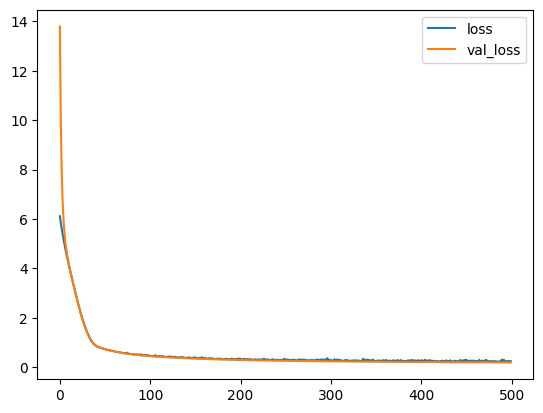

In [12]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

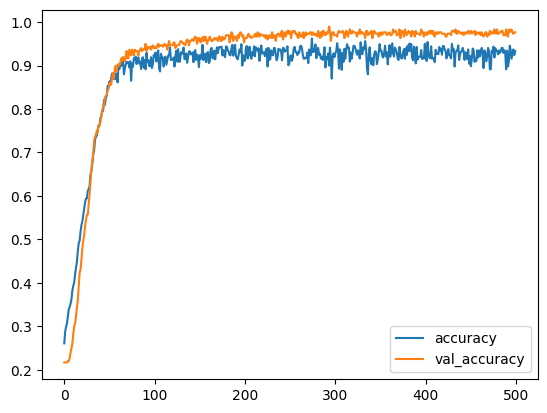

In [13]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [14]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.18826308846473694, 0.9933333396911621]

Train data evaluation:
[0.19801810383796692, 0.977142870426178]


In [15]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<Axes: >

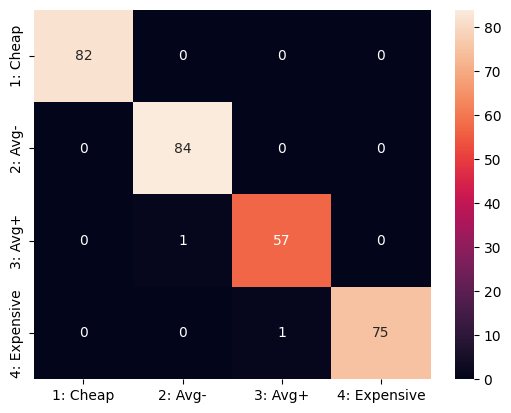

In [16]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

In [17]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions, target_names=categories))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

    1: Cheap       1.00      1.00      1.00        82
     2: Avg-       0.99      1.00      0.99        84
     3: Avg+       0.98      0.98      0.98        58
4: Expensive       1.00      0.99      0.99        76

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300


Model overall accuracy: 99.33%


In [18]:
# In multi category classification , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


0.9995306666666667

In [19]:
df.columns

Index(['battery_power', 'fc', 'int_memory', 'mobile_wt', 'n_cores', 'pc',
       'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time',
       'price_range'],
      dtype='object')

In [20]:
# let's try with some new imaginary data
# modify this as needed regarding your own dataset
tester_row = {
    'battery_power': 800, 
    'fc': 12, 
    'int_memory': 2,  
    'mobile_wt': 300, 
    'n_cores': 4, 
    'pc': 36,
    'px_width': 1890,
    'px_height': 1222, 
    'ram': 8096,
    'sc_h': 13, 
    'sc_w': 4, 
    'talk_time': 19
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
result_text = categories[np.argmax(result)]

# 0 cheapest, 3 most expensive
print("-> 0 cheapest, 3 most expensive category")
print(f"Predicted price range: {result_text}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
-> 0 cheapest, 3 most expensive category
Predicted price range: 4: Expensive
